In [2]:
import os
import sys

import numpy as np
import pandas as pd

from scipy.stats import norm
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.stats import randint

import seaborn as sns
import matplotlib.pyplot as plt

# Constants

In [3]:
RANDOM_STATE = 42 # to get the same random values with different .ipynb sessions
N_ITER = 3 # number of iterations while searching hyperparameters of the model
N_CV = 5 # number of folds in crossvalidation
N_JOBS = 2 # number of jobs for parallelization

In [4]:
PROJECT_PATH = os.getcwd() # get current working directory
PROJECT_PATH = os.path.join(PROJECT_PATH, "..") # go to higher folder 

DATA_PATH = os.path.join(PROJECT_PATH, "data") # define path to the data

In [5]:
sys.path.append(PROJECT_PATH) # add higher direcotory to load self-written metrics
from tools.metrics import * 

# Read Data

In [6]:
df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"), encoding="cp1252",)
df.drop(columns=['id'], inplace=True)

In [7]:
df.head()

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,host_response_rate,latitude,log_price,longitude,number_of_reviews,...,Waterfront,first_review_Year,first_review_Month,first_review_Day,last_review_Year,last_review_Month,last_review_Day,host_since_Year,host_since_Month,host_since_Day
0,3,1.0,1.0,1.0,1,0,40.696524,5.010635,-73.991617,2,...,0,2016.0,6.0,18.0,2016.0,7.0,18.0,2012.0,3.0,26.0
1,7,1.0,3.0,3.0,1,100,40.766115,5.129899,-73.989040,6,...,0,2017.0,8.0,5.0,2017.0,9.0,23.0,2017.0,6.0,19.0
2,5,1.0,1.0,3.0,1,100,40.808110,4.976734,-73.943756,10,...,0,2017.0,4.0,30.0,2017.0,9.0,14.0,2016.0,10.0,25.0
3,4,1.0,2.0,2.0,1,0,37.772004,6.620073,-122.431619,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,4.0,19.0
4,2,1.0,0.0,1.0,1,100,38.925627,4.744932,-77.034596,4,...,0,2015.0,5.0,12.0,2017.0,1.0,22.0,2015.0,3.0,1.0


In [8]:
df.describe()

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,host_response_rate,latitude,log_price,longitude,number_of_reviews,...,Waterfront,first_review_Year,first_review_Month,first_review_Day,last_review_Year,last_review_Month,last_review_Day,host_since_Year,host_since_Month,host_since_Day
count,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,...,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000,74111.000000
mean,3.155146,1.231929,1.264239,1.707844,0.734075,71.055201,38.445958,4.782069,-92.397525,20.900568,...,0.001552,1584.095438,5.146469,12.129603,1586.010133,5.204814,13.178948,2008.941992,6.524268,15.595957
std,2.153589,0.584780,0.852773,1.255092,0.441828,43.087044,3.080167,0.717394,21.705322,37.828641,...,0.039362,826.712164,3.898664,10.152619,826.482416,3.707618,10.650738,101.328302,3.334992,8.809573
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.338905,0.000000,-122.511500,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,34.127908,4.317488,-118.342374,1.000000,...,0.000000,2013.000000,1.000000,2.000000,2015.000000,1.000000,1.000000,2013.000000,4.000000,8.000000
50%,2.000000,1.000000,1.000000,1.000000,1.000000,100.000000,40.662138,4.709530,-76.996965,6.000000,...,0.000000,2015.000000,5.000000,11.000000,2017.000000,5.000000,14.000000,2014.000000,7.000000,16.000000
75%,4.000000,1.000000,1.000000,2.000000,1.000000,100.000000,40.746096,5.220356,-73.954660,23.000000,...,0.000000,2016.000000,8.000000,21.000000,2017.000000,9.000000,23.000000,2015.000000,9.000000,23.000000
max,16.000000,8.000000,10.000000,18.000000,1.000000,100.000000,42.390437,7.600402,-70.985047,605.000000,...,1.000000,2017.000000,12.000000,31.000000,2017.000000,12.000000,31.000000,2017.000000,12.000000,31.000000


# Exploratory Data Analysis

In [9]:
# define list of columns to train model
COLS_TO_TRAIN = []

# Descriptive statistics

In [10]:
# code for feature selection

# Generate train, test

Data is split into 2 parts:

    - train - 80% of observations
    
    - test - 20% of observations
    
    
Train will be used to train a model.

Test - to evaluate its performance.

In [11]:
targets = df['log_price']
features = df.drop(columns=['log_price'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    features, targets, train_size=0.8, random_state=RANDOM_STATE, shuffle=True
)

In [12]:
print("Check shapes of inputs to the model (train stage): ")
print("Features: ", x_train.shape)
print("Target: ", y_train.shape)

Check shapes of inputs to the model (train stage): 
Features:  (59288, 211)
Target:  (59288,)


In [13]:
print("Check shapes of inputs to the model (test stage): ")
print("Features: ", x_test.shape)
print("Target: ", y_test.shape)

Check shapes of inputs to the model (test stage): 
Features:  (14823, 211)
Target:  (14823,)


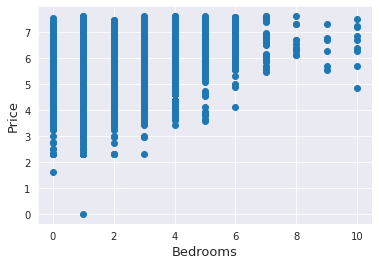

In [26]:
fig, ax = plt.subplots()
ax.scatter(x = x_train['bedrooms'], y = y_train)
plt.ylabel('Price', fontsize=13)
plt.xlabel('Bedrooms', fontsize=13)
plt.show()

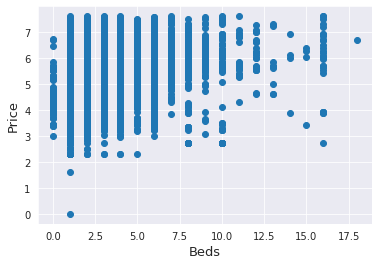

In [28]:
fig, ax = plt.subplots()
ax.scatter(x = x_train['beds'], y = y_train)
plt.ylabel('Price', fontsize=13)
plt.xlabel('Beds', fontsize=13)
plt.show()

/home/dichik/Public/PycharmProjects/nw/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


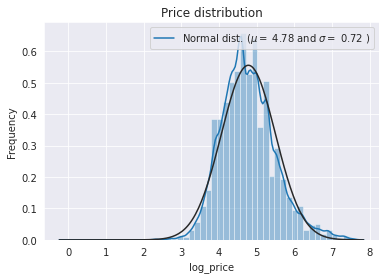

In [34]:
sns.distplot(y_train , fit=norm)

(mu, sigma) = norm.fit(y_train)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

plt.show()

In [35]:
x_train.dtypes

accommodates           int64
bathrooms            float64
bedrooms             float64
beds                 float64
cleaning_fee           int64
                      ...   
last_review_Month    float64
last_review_Day      float64
host_since_Year      float64
host_since_Month     float64
host_since_Day       float64
Length: 211, dtype: object

# Develop a model

In [14]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

param_grid = { 
                "n_estimators": [10, 100, 200],
                "max_features": ["sqrt", "log2"],
                "bootstrap": [True, False]
             }

# initialize random search object
rfr = RandomizedSearchCV(rfr, param_grid, random_state=RANDOM_STATE, n_iter=N_ITER, cv=N_CV, n_jobs=N_JOBS)

# search for the optimal model's hyperparameters
search = rfr.fit(x_train, y_train)

In [15]:
# optimal model's hyperparameters
search.best_params_

{'n_estimators': 100, 'max_features': 'log2', 'bootstrap': False}

In [16]:
assert search.best_score_ == search.cv_results_["mean_test_score"][search.best_index_]

In [17]:
# initialize Random Forest with the optimal hyperparameters
rfr = RandomForestRegressor(
    random_state=RANDOM_STATE, 
    **search.best_params_
)

# train it
rfr.fit(x_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='log2', random_state=42)

In [18]:
y_pred = rfr.predict(x_test)
print("R^2 : ", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test, y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

R^2 :  0.6609436307288625
MAE : 0.30511698187373437
RMSE: 0.4173512165544046


In [19]:
pd.DataFrame(y_pred, columns=['predicted_price']).to_csv(os.path.join(DATA_PATH, "predicted_price.csv"), index=False)

# Metrics

In [20]:
# code

### Precision Recall Curve, AUC

In [21]:
# code 

### ROC Curve, ROC AUC

In [22]:
# code

## Inference

Compute metrics on the inference data

### Accuracy, Precision, Recall, Precision Recall AUC, ROC AUC

### Precision Recall Curve, AUC

### ROC Curve, ROC AUC

In [23]:
# code

# Population Stability Index (PSI)

**The population stability index (PSI)** is a statistic that measures how much a variable has shifted over time, and is used to monitor applicability of a statistical model to the current population.
Details by the [link](https://scholarworks.wmich.edu/cgi/viewcontent.cgi?article=4249&context=dissertations#:~:text=The%20population%20stability%20index%20(PSI,model%20to%20the%20current%20population.)


In [24]:
# code for psi